### Goal of this projet: 
Try to identify a systematic process by which the microbiome deconstructs (losses diversity).
By using inverse simpson score and the HCT dataset, I create another data set that represents 3 consectutive decreases in inverse simpson score for a specific patient. Using unsupervised clustering we identify the major patterns in this deconstruction dataset. 

In [3]:
df_tax

,ASV,Sequence,Kingdom,Phylum,Class,Order,Family,Genus,ConfidenceKingdom,ConfidencePhylum,ConfidenceClass,ConfidenceOrder,ConfidenceFamily,ConfidenceGenus,HexColor,ColorOrder
0,ASV_1,AGCGCAGGCGGTTGCTTAGGTCTGATGTGAAAGCCTTCGGCTTAAC...,Bacteria,Firmicutes,Bacilli,Lactobacillales,Lactobacillaceae,Lactobacillus,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,#1635A4,163
1,ASV_10,AGCGTAGACGGAAGAGCAAGTCTGATGTGAAAGGCTGGGGCTTAAC...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,100.000000,100.000000,100.000000,100.000000,100.000000,95.798963,#AD998C,7
2,ASV_100,AGCGTAGATGGATGTTTAAGTCAGTTGTGAAAGTTTGCGGCTCAAC...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,100.000000,98.803795,98.803795,98.803795,98.803795,98.803795,#16DDD3,44
3,ASV_1000,TGCGTAGGTGGTTTCTTAAGTCAGAGGTGAAAGGCTACGGCTCAAC...,Bacteria,Firmicutes,Clostridia,Clostridiales,Peptostreptococcaceae,Romboutsia,94.028092,94.028092,94.028092,94.028092,94.028092,78.184492,#BEA89A,21
4,ASV_10000,AGCGTAGACGGTGTGGCAAGTCTGATGTGAAAGGCATGGGCTCAAC...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,<not present>,98.262969,98.262969,97.774085,97.774085,97.774085,97.774085,#BEA89A,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17860,ASV_9992,GGAGCAGGCGGCAGCAAGGGTCTGTGGTGAAAGCCTGAAGCTTAAC...,Bacteria,Firmicutes,Erysipelotrichia,Erysipelotrichales,Erysipelotrichaceae,Erysipelatoclostridium,97.124732,97.124732,96.336821,96.336821,96.336821,96.336821,#FBA22E,84
17861,ASV_9994,AGCGTAGACGGTGTTGCAAGTCTGATGTGAAAGGCGGGGGCTCAAC...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,93.525885,93.525885,93.525885,93.525885,93.525885,64.132202,#BEA89A,21
17862,ASV_9996,AGCGTAGACGGAGCAGCAAGTCTGATGTGAAAACCCGGGGCTCAAC...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,[Ruminococcus] torques group,96.408836,96.408836,96.408836,96.408836,96.408836,85.154103,#BEA89A,21
17863,ASV_9997,AGCGTAGACGGTGTTGCAAGTCTGATGTGAAAGGCGGGGGCTCAAC...,Bacteria,Firmicutes,Clostridia,Clostridiales,Lachnospiraceae,Blautia,95.294088,95.294088,95.294088,95.294088,94.618748,64.147734,#BEA89A,21


In [1]:
import numpy as np
import pandas as pd
import hctmicrobiomemskcc.dataloading.dataloading as hct_data

data_dir = '/Users/brian/Documents/2021Spring/Jonas_Rotation/jupyterlab/hct_data'
df_ASV, df_colors, df_counts, df_stool = hct_data.load_microbiome_tables(local_dir=data_dir)
df_blood = hct_data.load_blood_data(local_dir=data_dir)
df_meta = hct_data.load_metadata(local_dir=data_dir)

# These data needed to be loaded local
df_tax = pd.read_csv('/Users/brian/Documents/2021Spring/Jonas_Rotation/jupyterlab/hct_data/taxonomy/tblASVtaxonomy_silva_v4v5_filter.csv')
df_sample = pd.read_csv('/Users/brian/Documents/2021Spring/Jonas_Rotation/jupyterlab/hct_data/samples/tblASVsamples.csv')
df_pcr = pd.read_csv('/Users/brian/Documents/2021Spring/Jonas_Rotation/jupyterlab/hct_data/counts/tblqpcr.csv')





Attempting to load data remotely... 
Phylum
Class
Order
Family
Genus
removing rows from the taxonomy table that correspond to eukaryotes, mitochondria, cloroplats, etc.
Removing counts of 16S sequences with unknown taxonomy / corresponding to chloroplasts, mitochondria, Archaea, or other non bacterial sources.
Data sucessfully loaded.
Attempting to load data remotely... 
Data sucessfully loaded.
Attempting to load data remotely... 
Data sucessfully loaded.


In [2]:
# Create new dataframes (df_sample_include, and df_counts_include that 
# subset the data to only samples within -14 and +21 days of transplant)
# Use df_meta["DayOfTransplant"] and df_sample["Day"] to find each Patient's DayOfTransplant from df_meta
# find all the SampleIDs that are between -14 and +21 of that day
# subset df_counts to include only these SampleIDs

df_sample_include=pd.DataFrame(columns=["SampleID","PatientID","Day","Consistency","Accession"])

for index,row in df_sample.iterrows():
    PatID=row.loc["PatientID"]
    
    DayofTrans=df_meta.loc[df_meta["PatientID"]== PatID]["DayOfTransplant"]
    if len(DayofTrans)!=1:
        continue
    DayofTrans=DayofTrans.item()
    Curr_Day=row["Day"]
    
    if (Curr_Day >(DayofTrans-14)) & (Curr_Day < (DayofTrans+21)):
        df_sample_include=df_sample_include.append({
                "SampleID":row[0],
                "PatientID":row[1],
                "Day":row[2],
                "Consistency":row[3],
                "Accession":row[4]},ignore_index=True)


#uses isin to check rows of df_counts that are in df_sample_include
df_counts_include=df_counts[df_counts["SampleID"].isin(df_sample_include["SampleID"])]


In [3]:
#create a new dataframe (df_comp) that has the phylum composition of each sampleID
import hctmicrobiomemskcc.tools.microbiotatools as hct_tools

df_comp=hct_tools.get_composition_at_taxlevel(df_counts_include,df_tax,"ASV")


In [4]:
#create a new dataframe, test, that includes inverse simpson score

#calcualte the inverse simpson index for each sampleID
inv_simp=df_comp.apply(lambda r: 1 / np.sum(r ** 2), axis=1)
inv_simp=inv_simp.to_frame()

#create a new dataframe, test, to melt together, contains patientID, sampleID and inverese_simpson_score
# sort by patient ID and DAY 
test=inv_simp.merge(df_sample, on = ['SampleID'])
test = test[['PatientID', 'SampleID',0, 'Day', 'Consistency', 'Accession']]
test=test.drop(['Consistency', 'Accession'], axis=1)
test=test.rename(columns={0: "inverse_simpson_score"})

In [6]:
# Create a new dataframe, df_consecutive, that contains samples that have 3 consecutive
# decreases in inverse simpson score. If a sample has multiple instances of this, takes the most diverse starting sampleID
# write a function that finds, within each sample, the most diverse sampleID, 


df_consecutive=pd.DataFrame(columns=["PatientID","S1_ID","S2_ID","S3_ID",
                                     "S1_score","S2_score","S3_score",
                                     "S1_Day","S2_Day","S3_Day"])

for x in test['PatientID'].unique():
    foo=test[test.PatientID  == x] #create a foo table to store data on each unique PatientID
    s=foo.sort_values(['Day']) #sort by day
    s=s["inverse_simpson_score"] #create a series of simpson scores for each sampleID for the current patient
    p=s.reset_index(drop="true") #series of simpson score with index reset
    total_days=len(p)-1 #the total number of days of sample collected
    
    if len(p)<=2:
        continue #if patient doesn't have enough samples then skip
    else:
        index_max=p.idxmax()
        s_index_max=s.idxmax()
        if index_max==total_days or index_max==total_days-1: #if the index of the max simpson score is the last day, skip
            continue
        elif p[index_max]>p[index_max+1] and p[index_max+1]>p[index_max+2] and foo.iloc[index_max,:]["Day"] < foo.iloc[index_max+1,:]["Day"] and foo.iloc[index_max+1,:]["Day"] < foo.iloc[index_max+2,:]["Day"]: #check if the next 2 indexs are consecutively downwards, and if the two days increa
            S1_ID=foo.iloc[index_max,:]["SampleID"]
            S2_ID=foo.iloc[index_max+1,:]["SampleID"]
            S3_ID=foo.iloc[index_max+2,:]["SampleID"]
            S1_Day=foo.iloc[index_max,:]["Day"]
            S2_Day=foo.iloc[index_max+1,:]["Day"]
            S3_Day=foo.iloc[index_max+2,:]["Day"]
            df_consecutive=df_consecutive.append({
                "PatientID":x, #change this to patient
                "S1_ID":S1_ID,
                "S2_ID":S2_ID,
                "S3_ID":S3_ID,
                "S1_score":p[index_max],
                "S2_score":p[index_max+1],
                "S3_score":p[index_max+2],
                "S1_Day":S1_Day,
                "S2_Day":S2_Day,
                "S3_Day":S3_Day},
                    ignore_index=True)

print('all done')
        

df_consecutive.head()

all done


,PatientID,S1_ID,S2_ID,S3_ID,S1_score,S2_score,S3_score,S1_Day,S2_Day,S3_Day
0,1000,1000A,1000B,1000C,13.289526,6.207122,2.102628,0,5,15
1,1001,1001A,1001B,1001D,14.795837,2.518080,1.995601,0,3,16
2,1002,1002B,1002C,1002D,5.394270,5.309356,4.424144,33,37,41
3,1007,1007A,1007B,1007C,11.555565,9.371772,1.591375,0,3,10
4,1008,1008A,1008B,1008C,12.777539,8.229844,5.885650,0,5,12


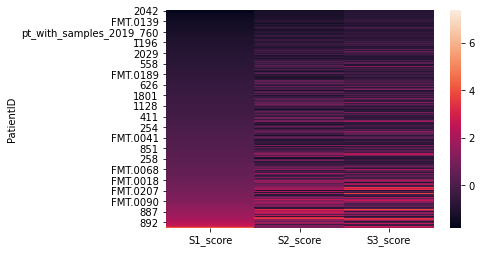

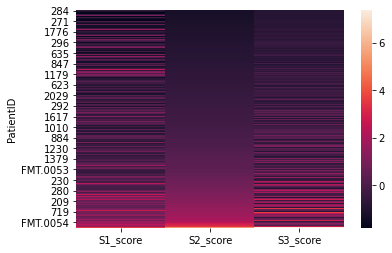

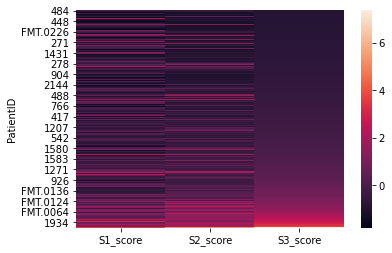

In [7]:
# creating a heatmap data frame
# feature scaling via standardization 
# scales features down based on standard normal distribution, mean=0, sdev= 1
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

df_heatmap=df_consecutive[["PatientID","S1_score","S2_score","S3_score"]]
df_heatmap=df_heatmap.set_index('PatientID')
df_heatmap[['S1_score', 'S2_score','S3_score']] = StandardScaler().fit_transform(df_heatmap[['S1_score', 'S2_score','S3_score']])

#sorting by various scores
df_heatmap_S1_sort= df_heatmap.sort_values(by=['S1_score'])
df_heatmap_S2_sort= df_heatmap.sort_values(by=['S2_score'])
df_heatmap_S3_sort= df_heatmap.sort_values(by=['S3_score'])

#scatter plot
plt.scatter(df_consecutive['S1_score'],df_consecutive['S3_score'])

#sorted by S1 z-scores
sns.heatmap(df_heatmap_S1_sort)
plt.show()

#sorted by S2 z-scores scores
sns.heatmap(df_heatmap_S2_sort)
plt.show()

#sorted by S3 z-scores
sns.heatmap(df_heatmap_S3_sort)
plt.show()

In [8]:
# create a dataframe of delta values, df_delta, that calcuates differnces between S1,S2, S3

df_delta=pd.DataFrame(columns=["PatientID","S1_ID","S2_ID","S3_ID","S1_S2","S2_S3", "S1_S3","D1_D2","D2_D3","D1_D3"])

for x in df_consecutive['PatientID']:
    S1_ID = df_consecutive.loc[df_consecutive["PatientID"] == x]["S1_ID"].values[0]
    S2_ID = df_consecutive.loc[df_consecutive["PatientID"] == x]["S2_ID"].values[0]
    S3_ID = df_consecutive.loc[df_consecutive["PatientID"] == x]["S3_ID"].values[0]
    S1_score=df_consecutive.loc[df_consecutive["PatientID"] == x]["S1_score"].values[0]
    S2_score=df_consecutive.loc[df_consecutive["PatientID"] == x]["S2_score"].values[0]
    S3_score=df_consecutive.loc[df_consecutive["PatientID"] == x]["S3_score"].values[0]
    S1_Day=df_consecutive.loc[df_consecutive["PatientID"] == x]["S1_Day"].values[0]
    S2_Day=df_consecutive.loc[df_consecutive["PatientID"] == x]["S2_Day"].values[0]
    S3_Day=df_consecutive.loc[df_consecutive["PatientID"] == x]["S3_Day"].values[0]
    df_delta=df_delta.append({"PatientID":x,
                              "S1_ID":S1_ID,
                              "S2_ID":S2_ID,
                              "S3_ID":S3_ID,
                              "S1_S2":S1_score-S2_score,
                              "S2_S3":S2_score-S3_score,
                              "S1_S3":S1_score-S3_score,
                              "D1_D2":S2_Day-S1_Day,
                              "D2_D3":S3_Day-S2_Day,
                              "D1_D3":S3_Day-S1_Day},ignore_index=True)
    
df_delta.head()

,PatientID,S1_ID,S2_ID,S3_ID,S1_S2,S2_S3,S1_S3,D1_D2,D2_D3,D1_D3
0,1000,1000A,1000B,1000C,7.082404,4.104494,11.186898,5,10,15
1,1001,1001A,1001B,1001D,12.277757,0.522479,12.800236,3,13,16
2,1002,1002B,1002C,1002D,0.084915,0.885212,0.970127,4,4,8
3,1007,1007A,1007B,1007C,2.183793,7.780397,9.964190,3,7,10
4,1008,1008A,1008B,1008C,4.547695,2.344195,6.891890,5,7,12


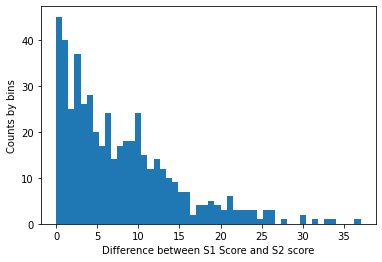

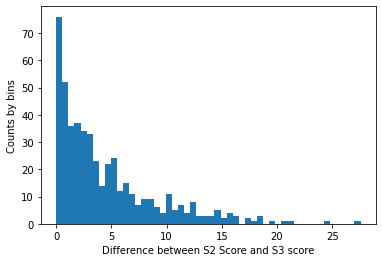

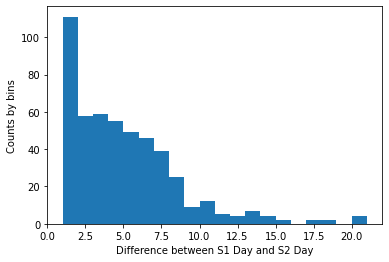

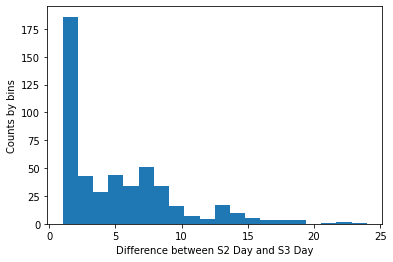

In [18]:
# visualizing deltas

x = df_delta['S1_S2']

plt.hist(x, bins=50)
plt.xlabel("Difference between S1 Score and S2 score")
plt.ylabel("Counts by bins")
plt.show()

x = df_delta['S2_S3']
plt.hist(x, bins=50)
plt.xlabel("Difference between S2 Score and S3 score")
plt.ylabel("Counts by bins")
plt.show()



#creates histogram of delta between S1_day and S2_day
x = df_delta['D1_D2']
plt.hist(x, bins=20)
plt.xlabel("Difference between S1 Day and S2 Day")
plt.ylabel("Counts by bins")
plt.show()



x = df_delta['D2_D3']
plt.xlabel("Difference between S2 Day and S3 Day")
plt.ylabel("Counts by bins")
plt.hist(x, bins=20)
plt.show()


Histogram barplots showing the delta between scores and days between S1-S2 and S2-S3. You see a greater decrease in S1-S2 scores compared to S2-S3 scores, as we would expected, since as time goes along, you have "less diversity to lose".

The delta days charts show that most of the records happen within 5 days of eachother. 

In [19]:
# Is there any correlation with the most abundance families and our consecutive dataset?
# create a dataframe, df_abund, that counts the most abundant families for each sampleID
# also add in color maps of most abundant families into dataframe for easier plotting
df_abund=pd.DataFrame(columns=["SampleID","Abundant"])
for index, row in df_comp.iterrows(): 
    max_index = row.idxmax()
    abund=df_tax.loc[df_tax["ASV"]==max_index]["Family"].values[0]
    df_abund=df_abund.append({"SampleID":index,"Abundant":abund},ignore_index=True)

#update df_delta and df_consecutive to contain the most abundant family
df_abund.columns= [ "S1_ID","Abundant"]
df_scatter_delta = df_delta.merge(df_abund, how = 'inner', on = ['S1_ID'])
df_scatter_consec = df_consecutive.merge(df_abund, how = 'inner', on = ['S1_ID'])

## update df_scatter_delta and df_scatter consec to include Abundant for S2
df_abund=df_abund.rename(columns={"S1_ID": "S2_ID", "Abundant": "Abundant_S2"})
df_foo_S2 = df_delta.merge(df_abund, how = 'inner', on = ['S2_ID'])

## update df_scatter_delta
df_abund=df_abund.rename(columns={"S2_ID": "S3_ID", "Abundant_S2": "Abundant_S3"})
df_foo_S3 = df_delta.merge(df_abund, how = 'inner', on = ['S3_ID'])

df_scatter_delta = pd.concat([df_scatter_delta, df_foo_S2['Abundant_S2'],df_foo_S3['Abundant_S3']], axis=1)

#update df_delta and df_consecutive to contain color maps
#add colormaps to df_scatter_consec, and df_scatter_delta
family_colors=df_colors.join(df_tax.set_index("ASV"),lsuffix = "_color").groupby("Family").agg("first")

family_colors['Abundant']=family_colors.index

df_family_colors=family_colors[["HexColor_color", "Abundant"]]
df_scatter_delta.join(df_family_colors,rsuffix='_color', on = 'Abundant')

df_scatter_delta = df_scatter_delta.join(df_family_colors,rsuffix='_color', on = 'Abundant')
df_scatter_consec = df_scatter_consec.join(df_family_colors,rsuffix='_color', on = 'Abundant')


In [20]:
#creating a master dataframe containing delta and raw S1, S2, S3 and Day values
foo = df_consecutive.drop(["PatientID","S1_ID","S2_ID","S3_ID"], axis= 1)
df_master=pd.concat([df_scatter_delta, foo], axis=1)
#df_master.drop(df_master.columns[["PatientID"]], axis = 1, inplace = True)
df_master.index=df_delta['PatientID']

df_master.to_csv('df_deconstruction.csv',index = False)
df_master.head()



,PatientID,S1_ID,S2_ID,S3_ID,S1_S2,S2_S3,S1_S3,D1_D2,D2_D3,D1_D3,...,Abundant_S2,Abundant_S3,HexColor_color,Abundant_color,S1_score,S2_score,S3_score,S1_Day,S2_Day,S3_Day
PatientID,,,,,,,,,,,,,,,,,,,,,
1000,1000,1000A,1000B,1000C,7.082404,4.104494,11.186898,5,10,15,...,Lactobacillaceae,Lactobacillaceae,#BEA89A,Ruminococcaceae,13.289526,6.207122,2.102628,0,5,15
1001,1001,1001A,1001B,1001D,12.277757,0.522479,12.800236,3,13,16,...,Erysipelotrichaceae,Enterobacteriaceae,#AD998C,Lachnospiraceae,14.795837,2.518080,1.995601,0,3,16
1002,1002,1002B,1002C,1002D,0.084915,0.885212,0.970127,4,4,8,...,Lactobacillaceae,Enterococcaceae,#BEA89A,Eubacteriaceae,5.394270,5.309356,4.424144,33,37,41
1007,1007,1007A,1007B,1007C,2.183793,7.780397,9.964190,3,7,10,...,Lachnospiraceae,Enterococcaceae,#AD998C,Lachnospiraceae,11.555565,9.371772,1.591375,0,3,10
1008,1008,1008A,1008B,1008C,4.547695,2.344195,6.891890,5,7,12,...,Lachnospiraceae,Acidaminococcaceae,#AD998C,Lachnospiraceae,12.777539,8.229844,5.885650,0,5,12


This is the dataset I will use to the machine learning portion. 
It contains:
PatientID : all PatientID who have stool samples collected between -14 and +21 days of transplant that had 3 consecutively decrease in diversity measurd by inverse simpson score, in the cases where one patient had multiple instances of consecutive decreases, the first instance was used. 
S1, S2, S3: SampleIDs of the 3 consecutive decreases
S1_score, S2_score, S3_score: Inverse simpson score of each sampleID
S1_Day, S2_Day, S3_Day: Day of drawn of inverse simpson score
S1_S2, S2_S3, S1_S3: Difference of score between each day (eg S2_S3 = S3_score - S2_score)
D1_D2, D2_D3, D1_D3: Difference in day
Abundant, Abundant_S2, Abundant_S3: The most abundant family measured on each S1, S2, S3 day
HexColor_color, Abundant_color: color map for most abundant familiy, currently only has S1 (Abundant)


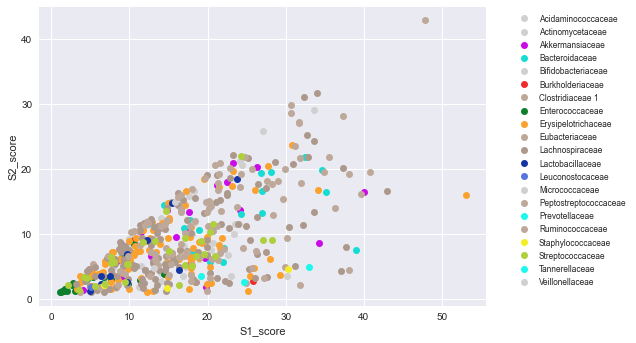

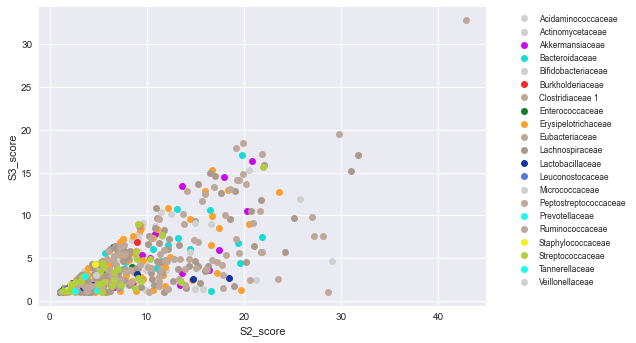

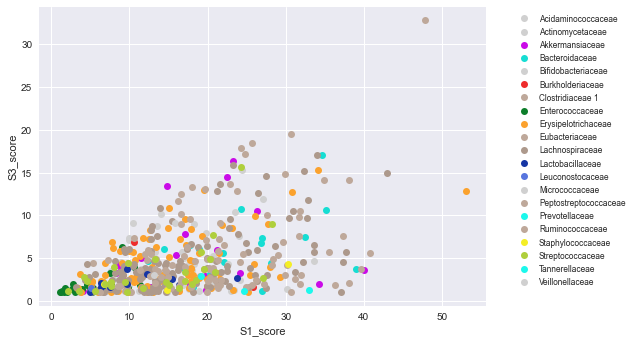

In [26]:
#create a plot with df_scatter_consec, plotting S1_score and S3_score as axis
#colored by most abundant bacteria family for S1

#use the colormap

import matplotlib.pyplot as plt
plt.style.use('seaborn')

groups = df_scatter_consec.groupby("Abundant")


for name, group in groups:
    colors=groups.get_group(name)['HexColor_color'].tolist()
    plt.plot(group["S1_score"],group["S2_score"],color=colors[0],label=name, marker = "o", linestyle="")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xlabel("S1_score")
    plt.ylabel("S2_score")
plt.show()
    
for name, group in groups:
    colors=groups.get_group(name)['HexColor_color'].tolist()
    plt.plot(group["S2_score"],group["S3_score"],color=colors[0],label=name, marker = "o", linestyle="")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xlabel("S2_score")
    plt.ylabel("S3_score")
plt.show()

for name, group in groups:
    colors=groups.get_group(name)['HexColor_color'].tolist()
    plt.plot(group["S1_score"],group["S3_score"],color=colors[0],label=name, marker = "o", linestyle="")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xlabel("S1_score")
    plt.ylabel("S3_score")
plt.show()


Plotting scores against each other. As we would expect, there is a positive trend, if you started with high S1 score, your S3 score will be high. Colored by most abundant famaly at the start (S1). I think most interesting graph is the S1, S3 graph whihc shows that there is a porpotion of samples that maintain high diversity score despite 3 consecutive decreases in inverse simpson score. 

## Kmeans Clustering

This portion will build a machine learning model to analyze
microbiome deconstruction within the HCT dataset
df_deconstruction dataset was generated by looking at patient samples
that had 3 consecutive decreases in inverse simpson scores 
within -14 and +21 days of HCT treatment
S1_S2, D1_D2 , D1_D3 etc ... are delta differences

In [28]:
df = pd.read_csv('/Users/brian/Documents/2021Spring/Jonas_Rotation/hctmicrobiome/notebooks/df_deconstruction.csv')

#cleaning up df, setting patientID as index, dropping Sample Ids and duplicate column 
df=df.set_index('PatientID')
df=df.drop(['S1_ID', 'S2_ID','S3_ID','Abundant_color'], axis=1)

#adding percentage change as a column 

df['perc_change_S1_S3']=df.apply(lambda x: x['S1_S3']*100/x['S1_score'], axis = 1)
df['perc_change_S1_S2']=df.apply(lambda x: x['S1_S2']*100/x['S1_score'], axis = 1)
df['perc_change_S2_S3']=df.apply(lambda x: x['S2_S3']*100/x['S2_score'], axis = 1)

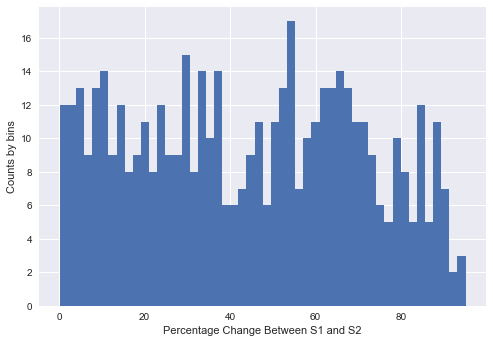

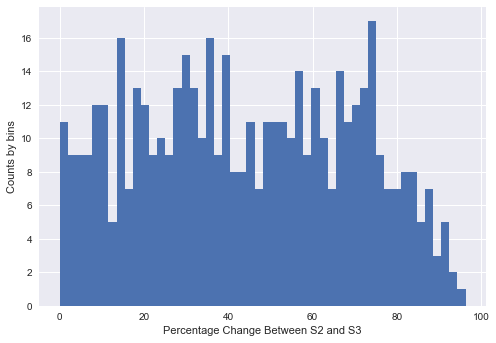

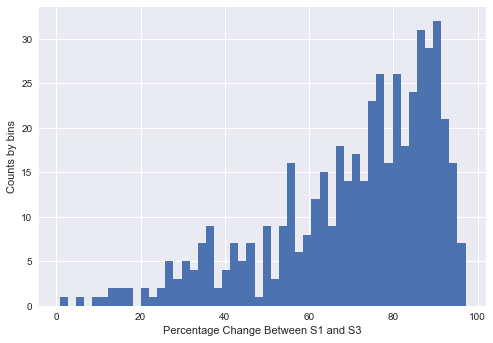

In [45]:
x = df['perc_change_S1_S2']
plt.hist(x, bins=50)
plt.xlabel("Percentage Change Between S1 and S2")
plt.ylabel("Counts by bins")
plt.show()

x = df['perc_change_S2_S3']
plt.hist(x, bins=50)
plt.xlabel("Percentage Change Between S2 and S3")
plt.ylabel("Counts by bins")
plt.show()

x = df['perc_change_S1_S3']
plt.hist(x, bins=50)
plt.xlabel("Percentage Change Between S1 and S3")
plt.ylabel("Counts by bins")
plt.show()




Plotting histogram of certain percentage changes between samples. Not sure what to make of S1_S2 and S2_S3...
It seems like S1_S2 there is potentially a bimodel distribution where half of the samples have between 1%-40% decrease and the other half has 40%-90% decrease?

Most interestingly S1_S3, the center (mean) of the distribution is quite high, roughly 80-85%.

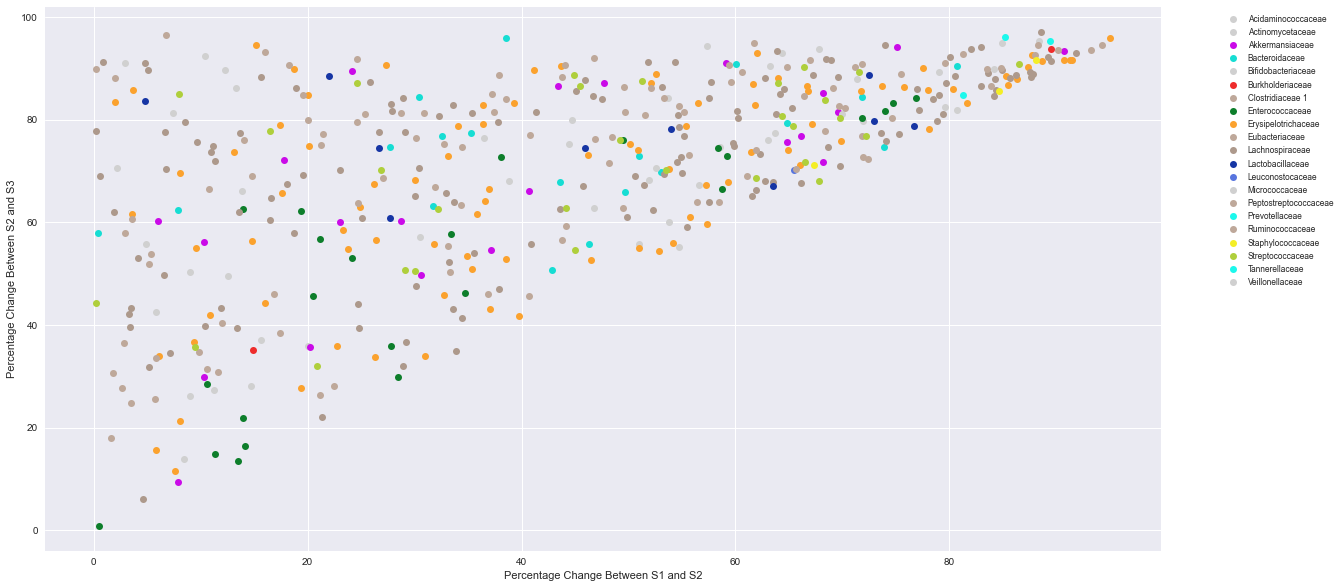

In [50]:
#percent change from S1 to S3 with colors mapped.

import matplotlib.pyplot as plt
plt.style.use('seaborn')

groups = df.groupby("Abundant")
plt.rcParams["figure.figsize"] = (20,10)
for name, group in groups:
    colors=groups.get_group(name)['HexColor_color'].tolist()
    plt.plot(group["perc_change_S1_S2"],group["perc_change_S1_S3"],color=colors[0],label=name, marker = "o", linestyle="")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.xlabel("Percentage Change Between S1 and S2")
    plt.ylabel("Percentage Change Between S1 and S3")




Trying to answer the question, what is the relationship between starting abundant family and percentage change. 
Plotted S1_S2 percentage change on the bottom and total percentage change (S1_S3).
If you have a greater starting percentage change (S1_S2) then your total percentage change will be greater. Does not seem to matter which family you start with

Text(0, 0.5, 'Percent Change (%)')

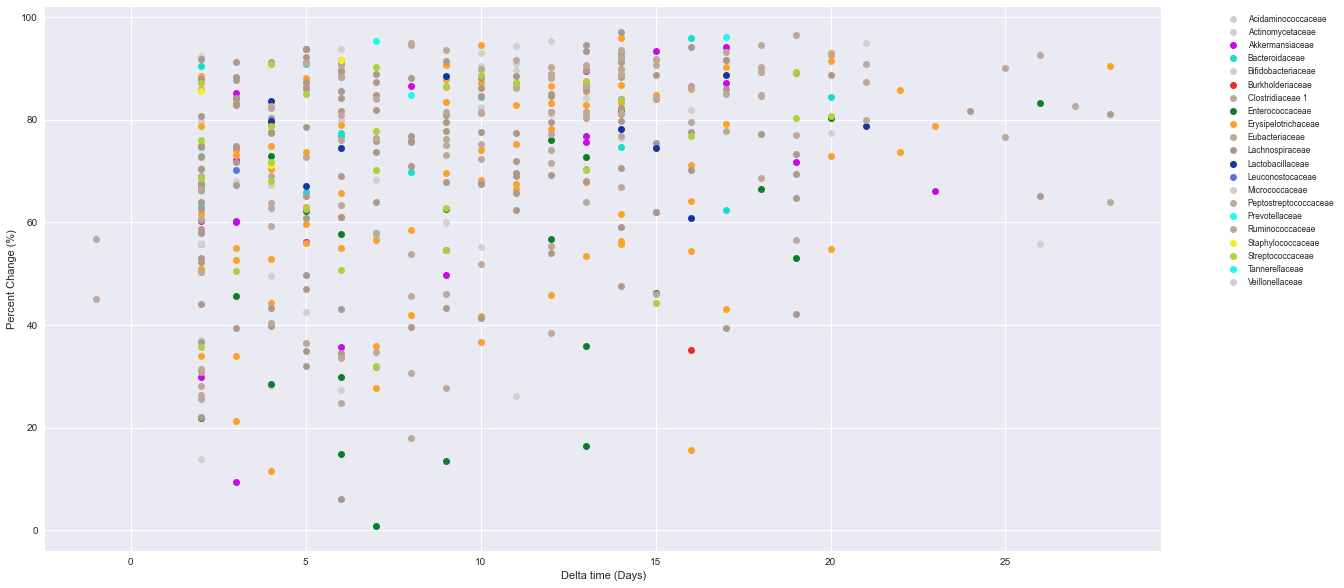

In [16]:
#perc change over delta time
#colored by most abundant bacteria family for S1

#use the colormap

import matplotlib.pyplot as plt
plt.style.use('seaborn')

groups = df.groupby("Abundant")
plt.rcParams["figure.figsize"] = (20,10)
for name, group in groups:
    colors=groups.get_group(name)['HexColor_color'].tolist()
    plt.plot(group["D1_D3"],group["perc_change_S1_S3"],color=colors[0],label=name, marker = "o", linestyle="")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.xlabel("Total Time inbetween samples")
plt.ylabel("Percent Change (%)")

#as you incease delta time, the percentage change increases


Decided to examine the relationship between time and percentage change.  It seems like has total time between sample increases, so does percentage change. This makes intuitive sense, more time = more likely to deconstruct. 

<AxesSubplot:>

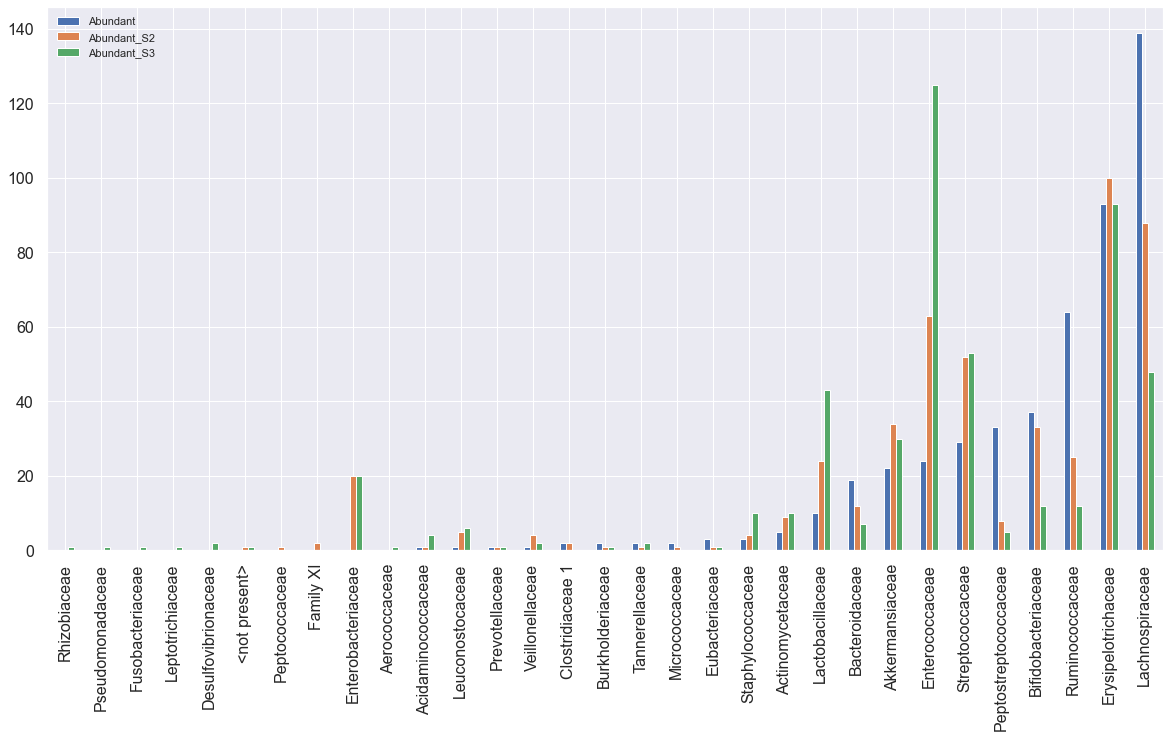

In [69]:
#create abundance dataframe to cluster and also plot

sns.set()
sns.set_palette("deep")

test=df['Abundant'].value_counts()[:]
test2=df['Abundant_S2'].value_counts()[:]
test3=df['Abundant_S3'].value_counts()[:]
df_abundance=pd.concat([test,test2,test3], axis=1)
df_abundance=df_abundance.fillna(0) #setting na's to zero

# bar plot of most abundant families colored by S1, S2, S3
df_abundance.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)


Barplot of most abundant families in S1 S2 and S3. Can we use this data to look for patterns in deconstruction of the microbiome?  Lachnospiraceae dominates early but decreases while Enterococaceae domininates later. Peptrostreptoccocaceae, bacteriodaceae,  bifidobacteriaceae, ruminocacceae and Lachnospiraceae all have a similar pattern of decrease as the dominant family over the course of deconstruction. While Lactobacillacea, enterococcacea, streptocooccaceae, staphylococaceae, actinomycetaceae all increase in abundance while diversity decreases. It is important to note this graph does not tell us what is happening to an individual patient over time (eg the patient becomes lachnospiracaea dominate, than loses it, and becomes enterococcaeceae) only the general trends (eg there are more lachnospiraceae dominate samples at S1 than there are at S3). 
Can we use unsupervised clustering methods to break down these trends into subgroups?

In [70]:
#k means clustering
from sklearn.cluster import KMeans
df_kmeans=df[['S1_score','S2_score','S3_score']]

# create a kmeans object
kmeans = KMeans(n_clusters = 3)
kmeans.fit(df_kmeans)

clusters = kmeans.cluster_centers_

#predicts our current data's clusters 
y_km = kmeans.fit_predict(df_kmeans)

df['kmeans_prediction'] = y_km

#saving df to csv
df.to_csv('df_2.csv',index = True)

In [71]:
##building a reshaped dataframe for plotting
import seaborn as sns
data=[]
for index, row in df.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0],df.loc[[index]]['kmeans_prediction'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0],df.loc[[index]]['kmeans_prediction'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0],df.loc[[index]]['kmeans_prediction'][0]])

df_shape=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant','Kmeans_prediction'])



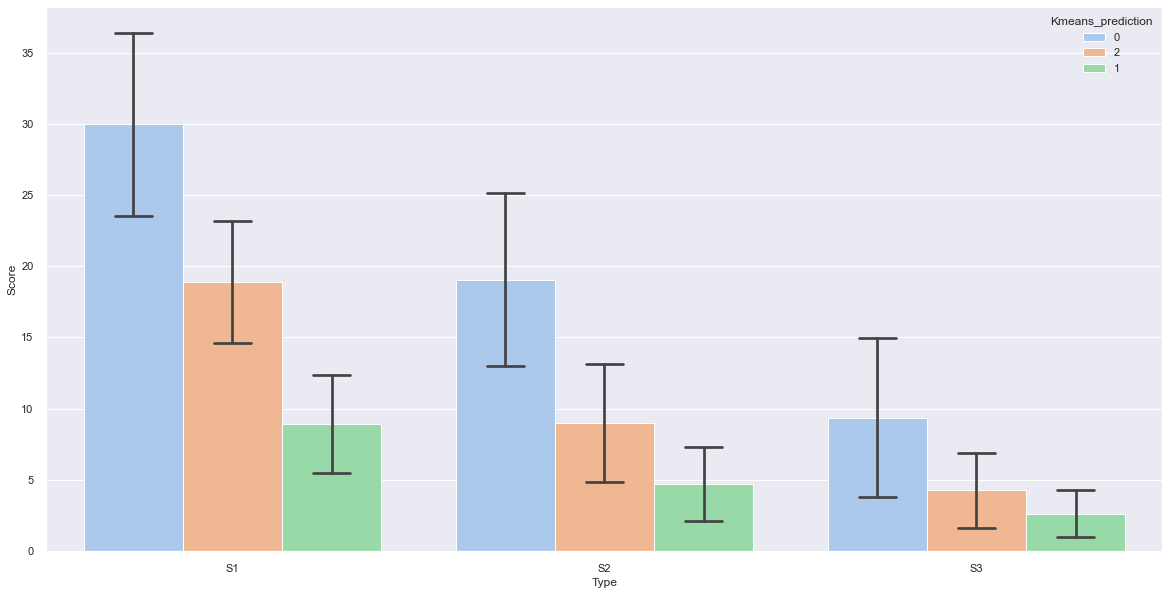

In [73]:
#visualizing kmeans

#subset each cluster into own group 
df_kmeans_0 = df[df['kmeans_prediction'] == 0]
df_kmeans_1 = df[df['kmeans_prediction'] == 1] 
df_kmeans_2 = df[df['kmeans_prediction'] == 2] 

#visualizing kmeans clusters

##kmeans cluster = 0
data=[]
for index, row in df_kmeans_0.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0]])

df_shape_0=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant'])

#kmeans cluster = 1
data=[]
for index, row in df_kmeans_1.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0]])

df_shape_1=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant'])


#kmeans cluster = 2
data=[]
for index, row in df_kmeans_2.iterrows():
    data.append([index,'S1',df.loc[[index]]['S1_score'][0],df.loc[[index]]['Abundant'][0]])
    data.append([index,'S2',df.loc[[index]]['S2_score'][0],df.loc[[index]]['Abundant_S2'][0]])
    data.append([index,'S3',df.loc[[index]]['S3_score'][0],df.loc[[index]]['Abundant_S3'][0]])

df_shape_2=pd.DataFrame(data, columns=['PatientID', 'Type', 'Score','Abundant'])

sns.set()
sns.set_palette("pastel")
sns.barplot(x="Type", y="Score", data=df_shape, capsize=.1, ci="sd", 
            hue = "Kmeans_prediction",hue_order=[0,2,1])


#sns.swarmplot(x="Type", y="Score", data=df_shape_0, color="0", alpha=.35)

#sns.swarmplot(x="Type", y="Score", data=df_shape_1, color="0.5", alpha=.35)
#sns.swarmplot(x="Type", y="Score", data=df_shape_2, color="1", alpha=.35)

plt.show()

Plot showing average score of the 3 clusters kmeans algorithmn generated. Jonas and I had hypothesized that maybe we would see 3 drastiically groups within the data (eg a group that starts high for S1 and S2 but drops off at S3, or a group that has a dramatic drop off between S1 and S2). Instead we see the algorithmn group based on the startind diversity, with 3 groups having a similar deconstruction trajectory.

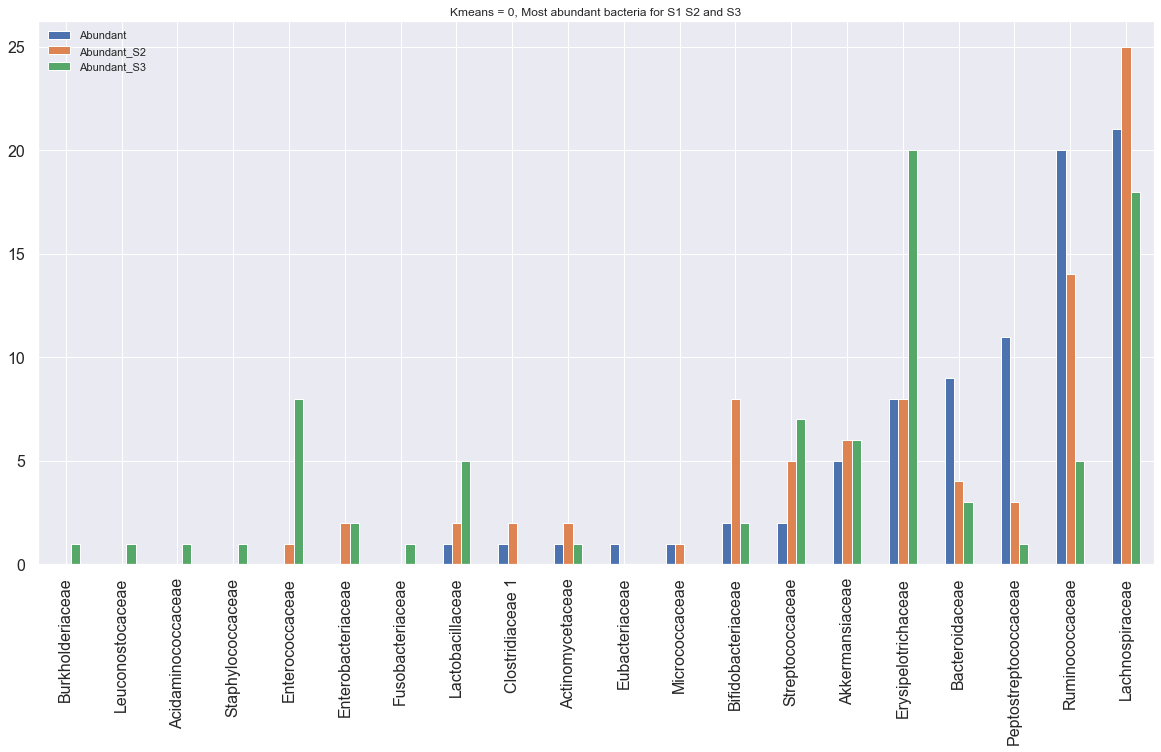

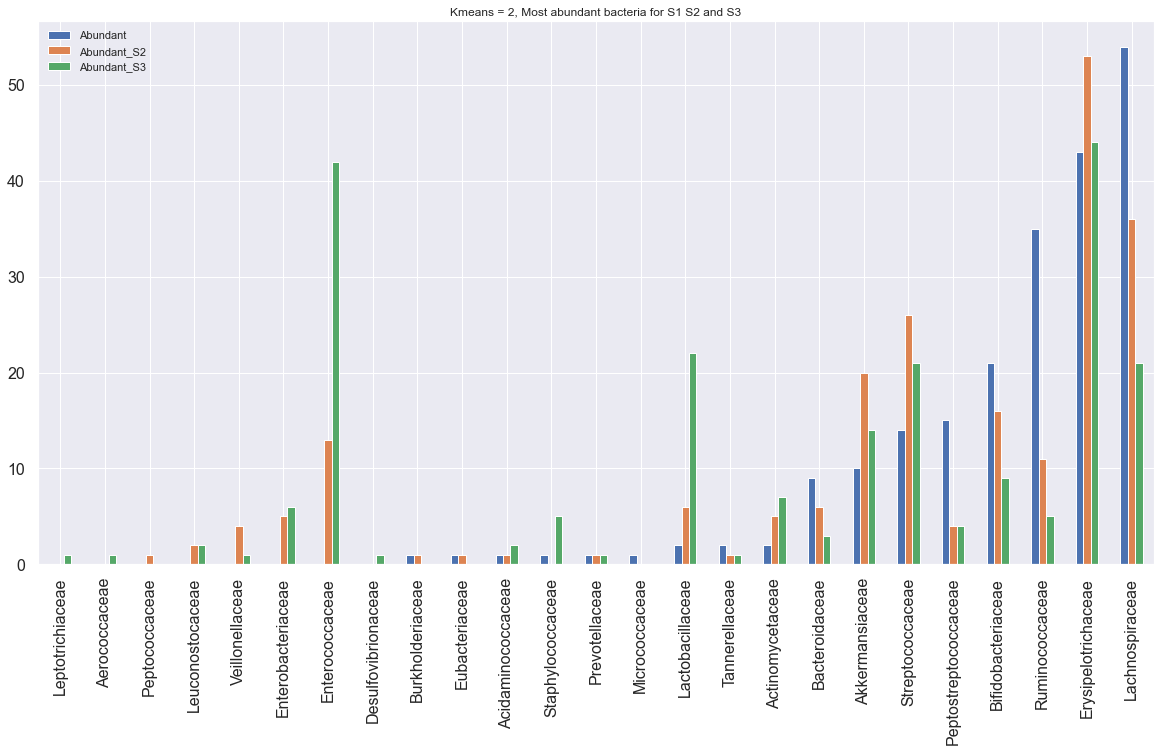

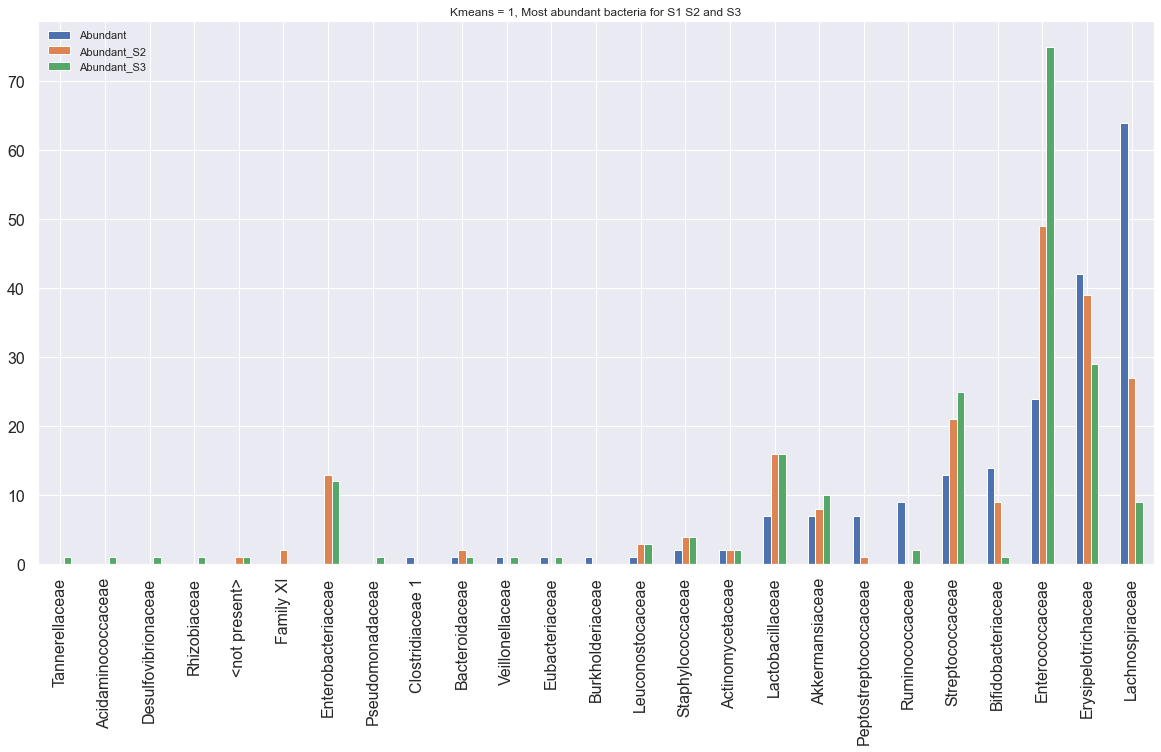

In [76]:
#plotting abundance bargraph but subset by kmeans clustering 

#create abundance dataframe 

sns.set()
sns.set_palette("deep")

test = df_kmeans_0['Abundant'].value_counts()[:]
test2 = df_kmeans_0['Abundant_S2'].value_counts()[:]
test3 = df_kmeans_0['Abundant_S3'].value_counts()[:]
df_abundance_k0 = pd.concat([test,test2,test3], axis=1)
df_abundance_k0 = df_abundance_k0.fillna(0) #setting na's to zero
df_abundance_k0.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)
plt.title('Kmeans = 0, Most abundant bacteria for S1 S2 and S3')
plt.show()

test = df_kmeans_2['Abundant'].value_counts()[:]
test2 = df_kmeans_2['Abundant_S2'].value_counts()[:]
test3 = df_kmeans_2['Abundant_S3'].value_counts()[:]
df_abundance_k2 = pd.concat([test,test2,test3], axis=1)
df_abundance_k2 = df_abundance_k2.fillna(0) #setting na's to zero
df_abundance_k2.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)
plt.title('Kmeans = 2, Most abundant bacteria for S1 S2 and S3')
plt.show()


test = df_kmeans_1['Abundant'].value_counts()[:]
test2 = df_kmeans_1['Abundant_S2'].value_counts()[:]
test3 = df_kmeans_1['Abundant_S3'].value_counts()[:]
df_abundance_k1 = pd.concat([test,test2,test3], axis=1)
df_abundance_k1 = df_abundance_k1.fillna(0) #setting na's to zero
df_abundance_k1.sort_values(by=['Abundant']).plot(kind='bar', fontsize= 16)
plt.title('Kmeans = 1, Most abundant bacteria for S1 S2 and S3')
plt.show()


Do these kmeans clusters any patterns we can learn from their most abundant families?

Note kmeans = 0 has the highest diversity score. kmeans = 2 is mid, kmeans = 1 is lowest. 

Kmeans group 0 starts with the highest diversity score and ends with the highest diversity score. This group's lachnospiracaeae counts stay relatively similar compared to k = 2 and k = 1. 
Ruminococcaceae, peptostreptococcaceae, bacteriodaceae decrease.  
Enterococcaceae, lactobacillaceae, erysipelotrichaceae, and streptococcaceae increase.

Kmeans 2 is the middle group. 
Lachnospiraceae, ruminocaceae, bifidobacteriaceae start out dominating and eventually decrease by S3. 
Enterococcacea and lactobacillaceae increase

Kmeans 1 starts with the lowest diversity score and ends with the lowest. 
Lachnospiraceae, erysipelotrichaceae, bifidobacteriaceae all decrease. 
Enterococcaceae, streptococcaceae, lactobacillaceae and enterobacteriaceae all increase. 

All three groups end up with enterococcaceae/lactobacillaceae increases from the start. K = 0, the group with the highest starting diversity is the only group that did not show a marked decrease in lachnospiracaeae. Is there a more quantitative approach to analysis this data? 

Does the S2 group from K = 0 resemble the S1 group of K = 2?
Does the S3 group from K = 0 resemble the S2 grop of K = 2? 

Does the S2 group from K = 2 resemble the S1 group for K = 1?
Does the S3 group from K = 2 resemble the S2 grop of K = 1? 

Would this reveal a reliable pattern of deconstruction within the microbiome?